In [1]:
%matplotlib notebook
import numpy             as np
import matplotlib.pyplot as plt
import corner
from tqdm import tqdm
import scipy.integrate as integrate
import matplotlib.animation as anim

In [2]:
def Prior(p):
    return np.piecewise(p, [p >= 0 and p <=1, p<0 and p>1],[lambda p: 1,lambda p: 0])
Prior = np.vectorize(Prior)

In [3]:
def Likelihood(p,r,n):
    return p**r*(1-p)**(n-r)

In [4]:
def Posterior(p,r,n):
    return Likelihood(p,r,n)*Prior(p)

In [5]:
p = np.linspace(0.,1.,1000)
r = 7
n = 10
Pos = Posterior(p,r,n)

In [6]:
# integration
I,_ = integrate.quad(Posterior,p[0],p[-1],args=(r,n))
I

0.0007575757575757576

<IPython.core.display.Javascript object>


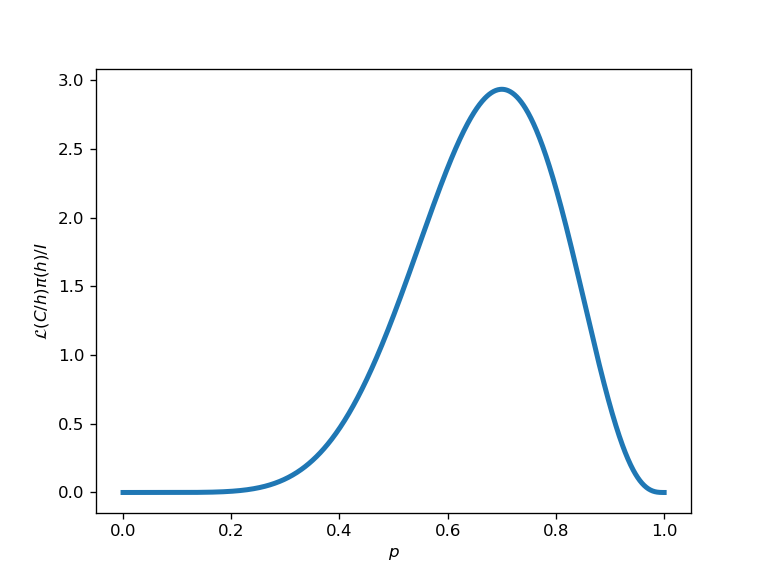

Text(0, 0.5, '$\\mathcal{L}(C/h)\\pi(h)/I$')

In [7]:
plt.plot(p,Pos/I,lw=3)
plt.xlabel(r'$p$',fontsize=10)
plt.ylabel(r'$\mathcal{L}(C/h)\pi(h)/I$',fontsize=10)

In [8]:
index = np.where(np.amax(Pos)==Pos)
hatp = p[index][0]
hatp

0.6996996996996997

In [9]:
sigma = np.sqrt(hatp*(1-hatp)/n); #Binomial error
sigma

0.14495517580957562

In [10]:
def Momento(p,r,n,k):
    return p**k*Posterior(p,r,n)/I

In [11]:
Mean,_ = integrate.quad(Momento,p[0],p[-1],args=(r,n,1))
print(Mean)

0.6666666666666667


In [12]:
Mean2, _ = integrate.quad(Momento,p[0],p[-1],args=(r,n,2))
print(Mean2)

0.4615384615384615


In [13]:
sigma = np.sqrt( Mean2 - Mean**2 )
sigma

0.13074409009212223

In [14]:
# Metropolis
def Metropolis(x0,Posterior,NSteps=int(1e4),delta = 0.4):
    
    x = np.zeros((NSteps,1))
    x[0] = x0
    
    for i in tqdm(range(1,NSteps)):
        
        P0 = Posterior(x[i-1],r,n)
        
        xf = x[i-1] + delta*2*(np.random.rand()-0.5)
        
        P1 = Posterior(xf,r,n)
        
        alpha = np.minimum(1,P1/P0)
        g = np.random.rand()
        
        if alpha > g:
            x[i,0] = xf
        else:
            x[i,:] = x[i-1,:]
    
    return x[100:,:]

In [15]:
initparams = np.array([0.2])
MCMC = Metropolis(initparams,Posterior)

100%|█████████████████████████████████████████████████████████| 9999/9999 [00:04<00:00, 2283.84it/s]


In [16]:
mean = np.percentile( MCMC,50 , axis=0 )
mean

array([0.68037675])

In [17]:
q = np.quantile(MCMC, q=[0.16,0.84],axis=0)
q

array([[0.53619275],
       [0.80121106]])

In [18]:
errorinf = mean-q[0]
errorsup = q[1]-mean
print(errorinf,errorsup)

[0.144184] [0.12083431]


In [19]:
np.mean([errorinf,errorsup])

0.13250915331751073

<IPython.core.display.Javascript object>


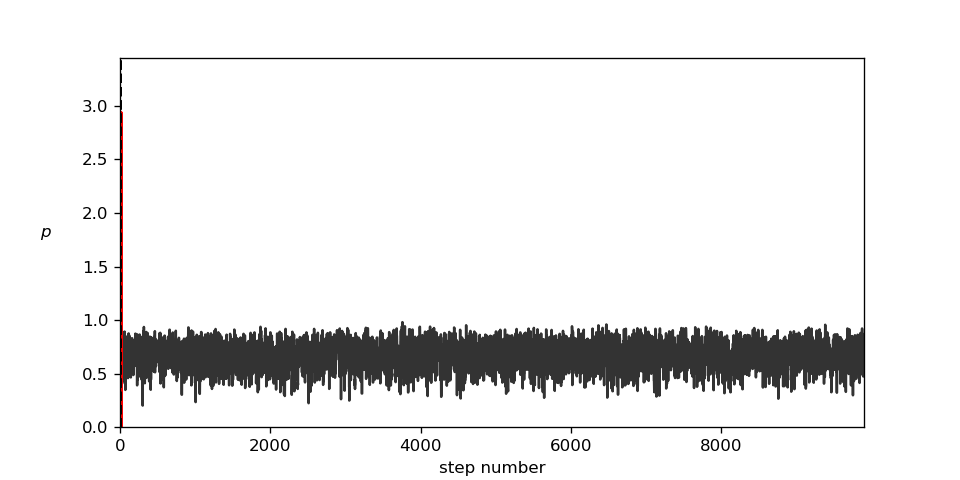

Text(0.5, 0, 'step number')

In [20]:
fig, axes = plt.subplots(len(initparams), figsize=(8, 4), sharex=True)
labels = ["$p$"]
for i in range(len(initparams)):
    #ax = axes[i]
    axes.plot(MCMC[:,i], 'k', alpha=0.8)
    axes.set_xlim(0, len(MCMC))
    axes.set_ylabel(labels[i], rotation=0)
    axes.yaxis.set_label_coords(-0.1, 0.5)
axes.set_xlabel("step number")

In [21]:
plt.hist(MCMC[:,0],bins=50,ec='b',density=True,alpha=0.7);
plt.plot(p,Pos/I,lw=3,color='r')
plt.axvline(x=mean,color='k',ls='--')
plt.axvline(x=q[0],color='k',ls='--')
plt.axvline(x=q[1],color='k',ls='--')

<IPython.core.display.Javascript object>


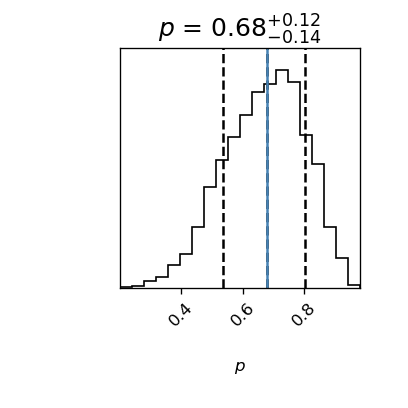

In [22]:
figure = corner.corner(MCMC, 
                       truths=mean, 
                       labels=labels, 
                       quantiles=[0.16,0.5,0.84], 
                       show_titles=True,
                       title_kwargs={"fontsize":15})

<IPython.core.display.Javascript object>


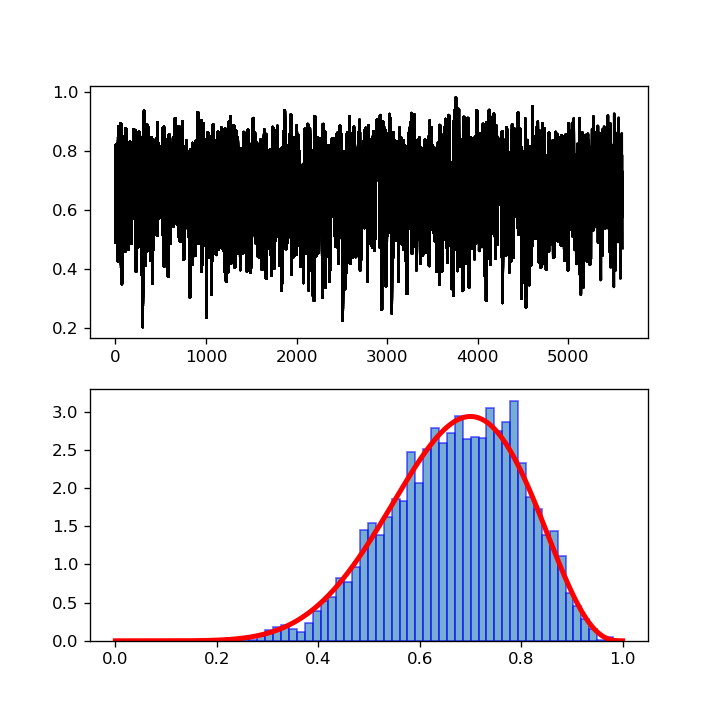

In [23]:
N = MCMC.shape[0]
#print(N)
fig = plt.figure(figsize=(6,6))

ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

def init():
    ax2.clear()

def Update(i):
    init()
    j = int(50*i)+1
    plot = ax1.plot(MCMC[:j,0],color='k')
    plot = ax2.hist(MCMC[:j,0],bins=50,density=True,ec='b',alpha=0.6)
    plot = ax2.plot(p,Pos/I,lw=3,color='r')
    
Animation = anim.FuncAnimation(fig,Update,frames=int(N/50))

In [24]:
Writer = anim.writers['ffmpeg']
writer = Writer(fps=10, metadata=dict(artist='Me'))
#Animation.save( 'MCMC.mp4', writer=writer )